# Assignment 2 Q3

**Section A**

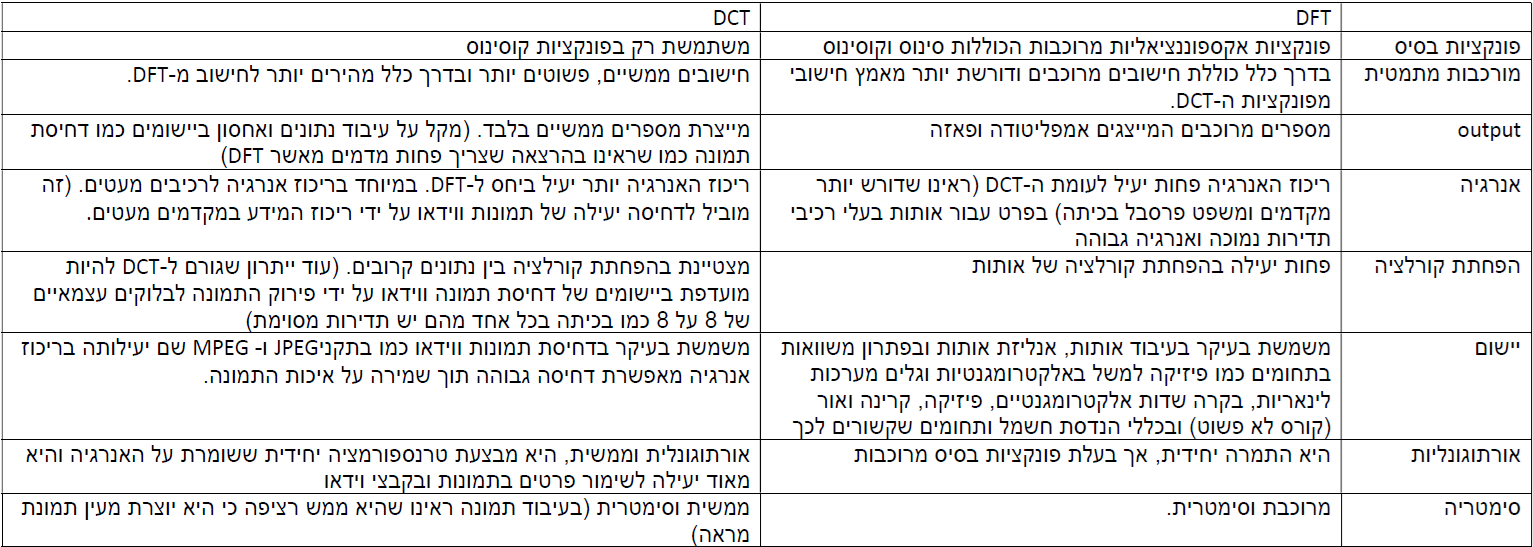

Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/MyDrive/Multimedia_Compression/HW2/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import metrics

Plot the resize Image

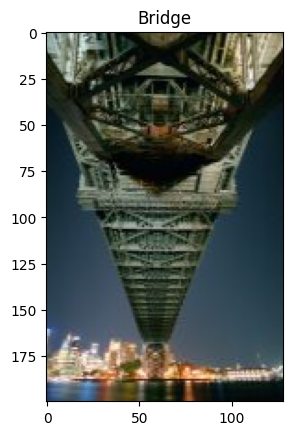

In [ ]:
'''bridge = cv2.imread(drive_path + 'bridge and Voldemort.jpg')'''
bridge = cv2.imread(drive_path + 'bridge.jpg')
bridge = cv2.cvtColor(bridge, cv2.COLOR_BGR2RGB)

original_height, original_width = bridge.shape[:2]
#original_height, original_width = original_height//10, original_width//10
new_height = (original_height // 8) * 8
new_width = (original_width // 8) * 8
bridge = cv2.resize(bridge, (new_width, new_height), cv2.INTER_AREA) # Resize the image

plt.title('Bridge')
plt.imshow(bridge)
plt.show()

**Explanation of why we did the resize**
Displaying the resized bridge image reduces computational load. Another benefit is that it fits the 7x7 window size used in the SSIM metric, avoiding the need to use a larger window, such as 100x100, for high-resolution images. Additionally, to prevent errors, the image dimensions are adjusted so that both rows and columns are divisible by 8. BTW We used cv2.INTER_AREA interpolation method because is specifically designed for shrinking images.

Divide the image into 8x8 pixel blocks

Here we divides the resized bridge image into **8x8 pixel blocks** for each color channel (R, G, B).


In [ ]:
bridge_channels_blocks = [[], [], []]
for i in range(0, bridge.shape[0], 8):  # Rows
    for j in range(0, bridge.shape[1], 8):  # Columns
        for channel in range(bridge.shape[2]):
            bridge_channels_blocks[channel].append(bridge[i:i+8, j:j+8, channel])

**Explanation**

We initialize a list called bridge_channels_blocks of three empty lists, one for each color channel (R, G, B). After that we start the loop over rows and columns. The outer loops iterate over the image dimensions in steps of 8 (to create 8x8 blocks). The last thing we do is channel-wise processing. For each 8x8 block, the corresponding color channel (R, G, or B) is extracted and appended to the appropriate list in bridge_channels_blocks.

This creates a structure where each channel is represented by a list of 8x8 blocks for applying the DCT on them.

Perform a DCT transform on the image.

In [ ]:
dct_bridge_channels_blocks = [[], [], []]  # One list for each channel (R, G, B)
for channel in range(3):
    for block in bridge_channels_blocks[channel]:
        dct_block = cv2.dct(block.astype(np.float32)) # Perform DCT
        dct_bridge_channels_blocks[channel].append(dct_block)

**Explanation**


We applies the DCT to each 8x8 block of the image for each color channel (R, G, B). First we initializes a list with 3 lists inside (for represent the channels) called dct_bridge_channels_blocks to store the transformed blocks for each channel. For each channel, it loops over the corresponding 8x8 blocks in bridge_channels_blocks, converts each block to float32 because it required for DCT, applies the DCT, and appends the transformed block to the respective list in dct_bridge_channels_blocks.

# Section B

## Defining Helper Functions

1. Reassemble the Image from Blocks


In [ ]:
def reassemble_image(blocks, image_shape):
    """ Reassemble 8x8 blocks into a full image. """
    rows, cols = image_shape[:2]
    image_reconstructed = np.zeros(image_shape, dtype=np.float32)

    block_size = 8
    for idx, block in enumerate(blocks):
        row = (idx // (cols // block_size)) * block_size
        col = (idx % (cols // block_size)) * block_size
        image_reconstructed[row:row+block_size, col:col+block_size] = block

    image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)
    return image_reconstructed

**Explanation**

The reassemble_image function reconstructs a full image from 8x8 blocks, which are the result of applying the IDCT after zeroing out specific DCT coefficients. The function also takes the dimensions of the resized image to ensure proper assembly.

First, the function extracts the number of rows and columns (which are multiples of 8) from the provided image dimensions. It uses the first two elements of the shape to ensure compatibility with multi-channel images (e.g., RGB). A new matrix of zeros is initialized to hold the reconstructed image. The block size is set to 8, and the function iterates over all blocks, placing them into their correct positions in the new image matrix based on their row and column indices.

Finally, the function clips the pixel values in the reconstructed matrix to the range [0, 255] to ensure valid pixel intensity values. The matrix is then converted to uint8, the standard format for image pixels, and the fully reconstructed image is returned.

2. Define the Zigzag Traversal Order

In [ ]:
def zigzag_indices():
    index_array = np.arange(64).reshape((8, 8))
    zz_indices = []

    for i in range(15): # 15 diagonals
        diag = [(x, y) for x in range(8) for y in range(8) if x + y == i]
        if i % 2 == 0: # Reverse every second diagonal
            diag = diag[::-1]
        zz_indices.extend(diag)

    zz_indices = [index_array[x, y] for x, y in zz_indices]
    return zz_indices

The zigzag_indices function returns the indices of an 8x8 matrix in a zigzag order like in the image of the section. First we created an 8x8 matrix that containing values from 0 to 63 in ascending order. The initial matrix looks like this:

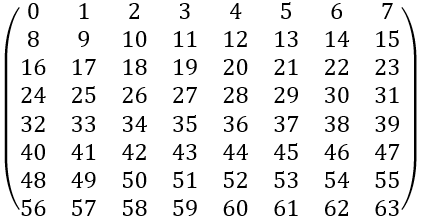

Next, the main loop calculates the indices of all diagonals in the matrix. In an 8x8 matrix, there are 15 diagonals, where the sum of the indices $i + j$ is constant for each diagonal. For example, for the first diagonal $i+j=0$, the value is 0, and for the second diagonal $i+j=1$, the values are $[1, 8]$. The full result for all diagonals is shown here:

Here is the Colab-friendly table representation for the diagonals, their indices, and values:

| **Diagonal** | **Indices**                         | **Values**         |
|--------------|-------------------------------------|--------------------|
| **0**        | $(0,0)$                          | $[0]$             |
| **1**        | $(0,1), (1,0)$                   | $[1, 8]$          |
| **2**        | $(0,2), (1,1), (2,0)$            | $[2, 9, 16]$      |
| **3**        | $(0,3), (1,2), (2,1), (3,0)$     | $[3, 10, 17, 24]$ |
| **4**        | $(0,4), (1,3), (2,2), (3,1), (4,0)$ | $[4, 11, 18, 25, 32]$ |
| **5**        | $(0,5), (1,4), (2,3), (3,2), (4,1), (5,0)$ | $[5, 12, 19, 26, 33, 40]$ |
| **6**        | $(0,6), (1,5), (2,4), (3,3), (4,2), (5,1), (6,0)$ | $[6, 13, 20, 27, 34, 41, 48]$ |
| **7**        | $(0,7), (1,6), (2,5), (3,4), (4,3), (5,2), (6,1), (7,0)$ | $[7, 14, 21, 28, 35, 42, 49, 56]$ |
| **8**        | (1,7), (2,6), (3,5), (4,4), (5,3), (6,2), (7,1) | $[15, 22, 29, 36, 43, 50, 57]$ |
| **9**        | $(2,7), (3,6), (4,5), (5,4), (6,3), (7,2)$ | [23, 30, 37, 44, 51, 58] |
| **10**       | $(3,7), (4,6), (5,5), (6,4), (7,3)$ | [31, 38, 45, 52, 59] |
| **11**       | $(4,7), (5,6), (6,5), (7,4)$ | [39, 46, 53, 60] |
| **12**       | $(5,7), (6,6), (7,5)$ | [47, 54, 61] |
| **13**       | $(6,7), (7,6)$ | [55, 62] |
| **14**       | $(7,7)$ | [63] |


Next, even diagonals like $i+j=0, 2, 4, \dots$ are reversed in their order. This changes the direction of the indices in those diagonals, resulting in the final zigzag sequence. After reversing the even diagonals, the following matrix is obtained:

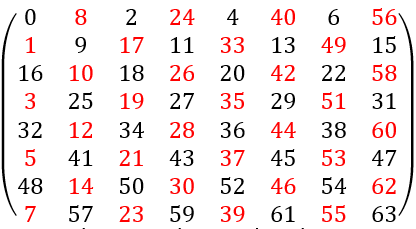

Finally, the indices of all the diagonals are collected into a single list in zigzag order. The resulting list looks like this:

image.png

Step 2: Discard DCT Coefficients According to Zigzag Order


In [ ]:
def discard_dct_coefficients(dct_block, num_discard):
    zz = zigzag_indices()
    flat_dct = dct_block.flatten() # Flatting
    for val in num_discard:
      flat_dct[zz[-val]] = 0  # - is for start from the end
    return flat_dct.reshape(8, 8)

The function discard_dct_coefficients takes an 8x8 DCT block and a list of positions that represent the coefficients to be zeroed out in zigzag order.

First, we call the zigzag_indices function to obtain the indices of the block in zigzag order. The 8x8 DCT matrix is then flattened into a one-dimensional array to make it easier to access specific coefficients by their index.
For each position in the input list num_discard, the function uses the zigzag indices to locate the corresponding coefficient in the flattened DCT array. Specifically, it accesses the desired position from the end of the zigzag list, retrieves the corresponding index, and zeros out the value at that position in the flattened DCT array.
After zeroing out the specified coefficients, the function reshapes the one-dimensional DCT array back into its original 8x8 form and returns the modified DCT block.
The bottom line is that we use this function to zero out the specified coefficients in zigzag order for every block in the DCT matrix.

## Section B1

In [ ]:
def section_B1(vanish_from_end):
  idct_blocks_B1 = [[], [], []]

  for channel in range(3):
      for block in dct_bridge_channels_blocks[channel]:
          processed_block = discard_dct_coefficients(block, vanish_from_end) # Vanish
          idct_blocks_B1[channel].append(cv2.idct(processed_block))

  reconstructed_channels = []
  for channel in range(3):  # Reassemble each channel
      reconstructed_channel = reassemble_image(idct_blocks_B1[channel], bridge[:, :, channel].shape)
      reconstructed_channels.append(reconstructed_channel)
  image_reconstructed = reassemble_image(idct_blocks_B1[channel], bridge[:, :, channel].shape)
  image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)
  return cv2.merge(reconstructed_channels)

vanish_from_end = [8, 12, 16, 20, 32, 50, 60]
reconstructed_image_B1 = section_B1(vanish_from_end)

Here we define a function that called section_B1 and the function  performs image reconstruction by zeroing out specific DCT coefficients in zigzag order. After that we applying the IDCT to each block, and reassembling the blocks into a complete image.

We begins by initializing separate lists for each color channel to store the IDCT-transformed blocks. For each channel, it processes all 8x8 DCT blocks in the dct_bridge_channels_blocks array. The function discard_dct_coefficients is called to zero out the specified coefficients, determined by the input list vanish_from_end. After modifying the DCT block, the IDCT is applied to reconstruct the spatial domain block, which is then appended to the corresponding channel list.

Once all blocks in a channel have been processed, the function reassembles them into a full image for that channel using the reassemble_image function. This step ensures that the reconstructed blocks are placed in their correct positions in the image matrix. The reassembled image for each channel is clipped to the valid range of pixel values (0-255) and converted to uint8 format for proper image representation.

Finally, the reconstructed channels are merged back into a single RGB image using cv2.merge function. The result is the reconstructed image with the specified DCT coefficients removed.

Then reset all the DCT elements according to the position you returned in the blocks according to the values.
Then restore the image and display it

## Section B2

In [ ]:
def section_B2(find_elemnt):
  # Adjust indices to zero-based (Seems so minor but caused so much headache in the last few paragraphs)
  fixed_find_elemnt = []
  for elemnt in find_elemnt:
    fixed_find_elemnt.append(elemnt - 1)
  find_elemnt = fixed_find_elemnt

  dct_variances = [] # Calculate variances for each coefficient
  for channel in range(3):
      all_blocks_flat = np.array([block.flatten() for block in dct_bridge_channels_blocks[channel]]) # Flatten all blocks (8x8=64)
      variances = np.var(all_blocks_flat, axis=0)  # Along the same coefficients
      dct_variances.append(variances)

  sorted_dct_variances = []
  for channel_variances in dct_variances:
      sorted_dct_variances.append(sorted(channel_variances)) # Sort variances

  positions = [[],[],[]]
  for i in range(3):
      for elemnt in find_elemnt:
          position = np.where(dct_variances[i] == sorted_dct_variances[i][elemnt]) # Identify positions of the lowest-variance coefficients by using np.where (find the index of the element with low variance)
          positions[i].append(position[0][0])

  modified_dct_bridge_channels_blocks = [[], [], []]
  for channel in range(3):
      for block in dct_bridge_channels_blocks[channel]:
          modified_block = block.copy()
          for position in positions[channel]:
              modified_block.flat[position] = 0  # Zero out the lowest-variance coefficients
          modified_dct_bridge_channels_blocks[channel].append(modified_block)

  # Reconstruct the image
  reconstructed_channels = []
  for channel in range(3):
      idct_blocks = [cv2.idct(block) for block in modified_dct_bridge_channels_blocks[channel]]
      reconstructed_channel = reassemble_image(idct_blocks, bridge.shape[:2])
      reconstructed_channels.append(reconstructed_channel)
  return cv2.merge(reconstructed_channels)

find_elemnt = [8, 12, 16, 20, 32, 50, 60]
reconstructed_image_B2 = section_B2(find_elemnt)

Now we define the function of this section and we called the function section_B2. The function processes the DCT-transformed image blocks to selectively zero out coefficients with the lowest variance across all blocks for each channel. It begins by adjusting the input list find_elemnt so that the elements align with zero-based indexing. Here we want to determine the positions of the least-variant coefficients in the zigzag order.

For each channel, the function flattens all 8x8 DCT blocks into 1D arrays of size 64 (as each block contains 64 coefficients). These flattened arrays are stacked together, and the variance of each coefficient is calculated across all blocks. Specifically, for a coefficient $k$, its mean $\mu_k$ and variance $\sigma_k^2$ are computed using the following formulas:

$$\mu_k = \frac{1}{N} \sum_{i=1}^{N} x_{i,k}, \quad \sigma_k^2 = \frac{1}{N} \sum_{i=1}^{N} (x_{i,k} - \mu_k)^2$$

where $N$ is the total number of blocks, $x_{i,k}$ is the $k$-th coefficient in the $i$-th block, and $\mu_k$ is the mean of the $k$-th coefficient for the current channel. The result is a variance vector of size 64, where each value represents the variance of a specific DCT coefficient.

```
Side note
We remember that Ofer showed a graph of the distribution of coefficients in class.
If our memory serves us correctly, each coefficient there was distributed in a nice Poisson manner, with the variance being the width.
We really wanted to illustrate it, but we couldn't find it.
```

The variances are then sorted, and the coefficients with the lowest variances, based on the find_elemnt, are identified for each channel. The corresponding indices of these coefficients are stored in positions.

Next, the function iterates over all blocks for each channel, creating modified copies of the blocks. For each block, the coefficients at the identified positions (low variance) are zeroed out. The modified blocks are stored in a new list.

After zeroing out the coefficients, the function performs an inverse DCT on the modified blocks to reconstruct the spatial domain image for each channel. These reconstructed blocks are reassembled into the full image for each channel, and the final reconstructed image is created by merging the three channels into an RGB image. The output is the reconstructed image with the specified low-variance DCT coefficients removed.

# Section C

## Display the original and reconstructed images

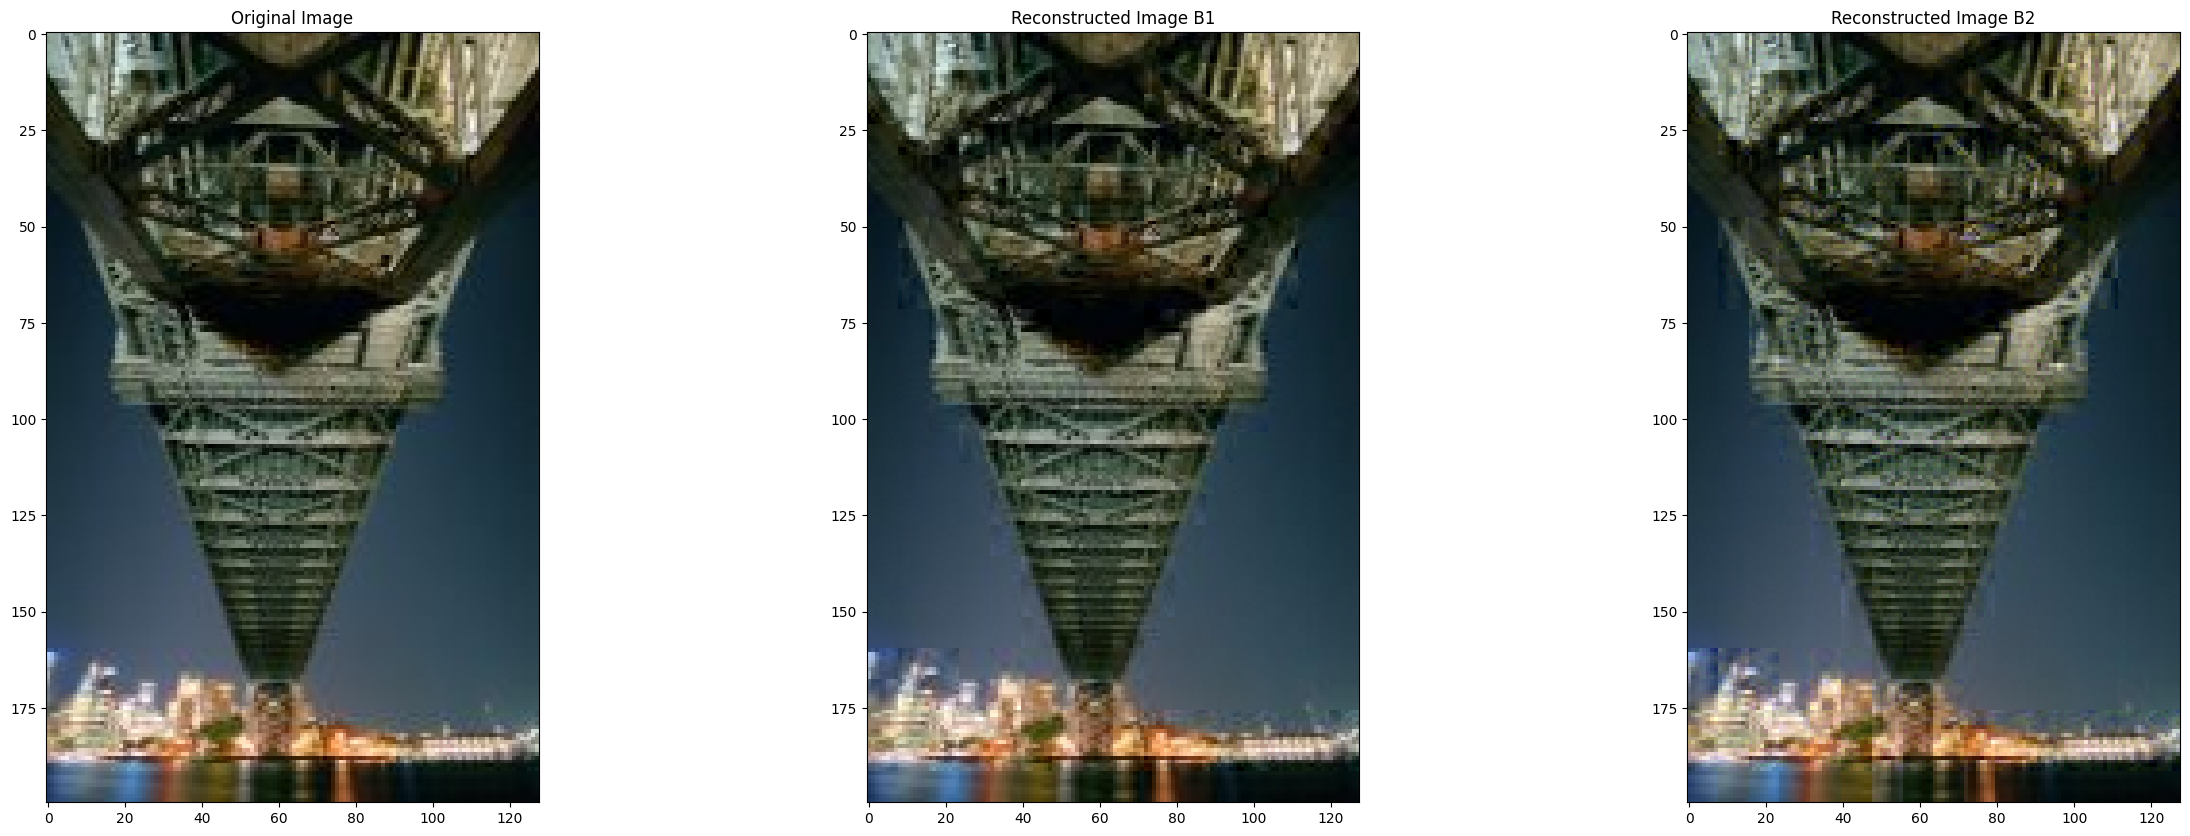

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(bridge)
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image_B1)
plt.title('Reconstructed Image B1')
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image_B2)
plt.title('Reconstructed Image B2')
plt.show()

## MSE, PSNR, SSIM functions

In [ ]:
def MSE(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

def PSNR(original, reconstructed):
    return metrics.peak_signal_noise_ratio(original, reconstructed, data_range=255)

def SSIM(original, reconstructed):
    # Multichannel=True for color images; channel_axis=-1 assumes channels are the last axis
    return metrics.structural_similarity(original, reconstructed, multichannel=True, channel_axis=-1, data_range=255)

## Plotting graphs of the quality indicators as a function of the number of coefficients discarded
A separate graph for each indicator containing the results from both methods.

### Compute Quality Metrics for Two Methods of Coefficient Discarding

In [ ]:
coefficients_to_discard = [list(range(1, i + 1)) for i in range(1, 65)] # The list of coefficients to discard

# The dictionary
results = {"mse": {"B1": [], "B2": []},"psnr": {"B1": [], "B2": []},"ssim": {"B1": [], "B2": []},}

for coeffs in coefficients_to_discard: # Metrics calculations

    reconstructed_B1 = section_B1(coeffs) # Method 1
    mse_B1 = MSE(bridge, reconstructed_B1)
    psnr_B1 = PSNR(bridge, reconstructed_B1)
    ssim_B1 = SSIM(bridge, reconstructed_B1)

    reconstructed_B2 = section_B2(coeffs) # Method 2
    mse_B2 = MSE(bridge, reconstructed_B2)
    psnr_B2 = PSNR(bridge, reconstructed_B2)
    ssim_B2 = SSIM(bridge, reconstructed_B2)

    # Save the results
    results["mse"]["B1"].append(mse_B1)
    results["psnr"]["B1"].append(psnr_B1)
    results["ssim"]["B1"].append(ssim_B1)
    results["mse"]["B2"].append(mse_B2)
    results["psnr"]["B2"].append(psnr_B2)
    results["ssim"]["B2"].append(ssim_B2)

**Code explanation**


We calculates and compares the image quality metrics (MSE, PSNR and SSIM) for two methods of discarding DCT coefficients. we use a range of coefficients to discard, incrementally increasing the number from 1 to 64. The coefficients_to_discard list contains sublists, where each sublist specifies the first n coefficients to discard.
For example in the first method we discard the 64 coff in the first iteartion then the discard 64,63 coff etc.

For each sublist in coefficients_to_discard, we reconstructs the image using B1 function and B2 function. In Method 1, the specified coefficients are discarded directly in zigzag order, while in Method 2, the coefficients with the lowest variance across blocks are discarded. After reconstructing the images for both methods, we calculates the MSE, PSNR and SSIM metrics by comparing the reconstructed images to the original image.

The calculated metric values for both methods are stored in a dictionary called results. This dictionary is structured to store separate metric values for each method under corresponding keys B1 and B2. The resulting data used to analyze and visualize the differences in quality between the two methods as the number of discarded coefficients increases.

### Visualizing Metric Comparisons for Two Methods Across Discarded Coefficients

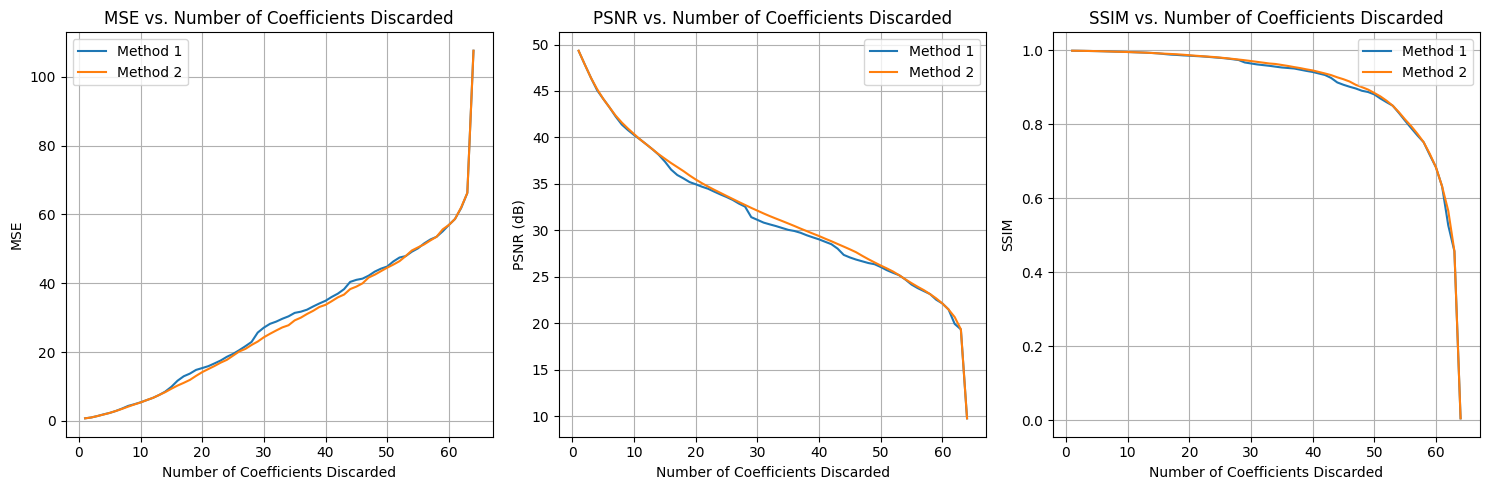

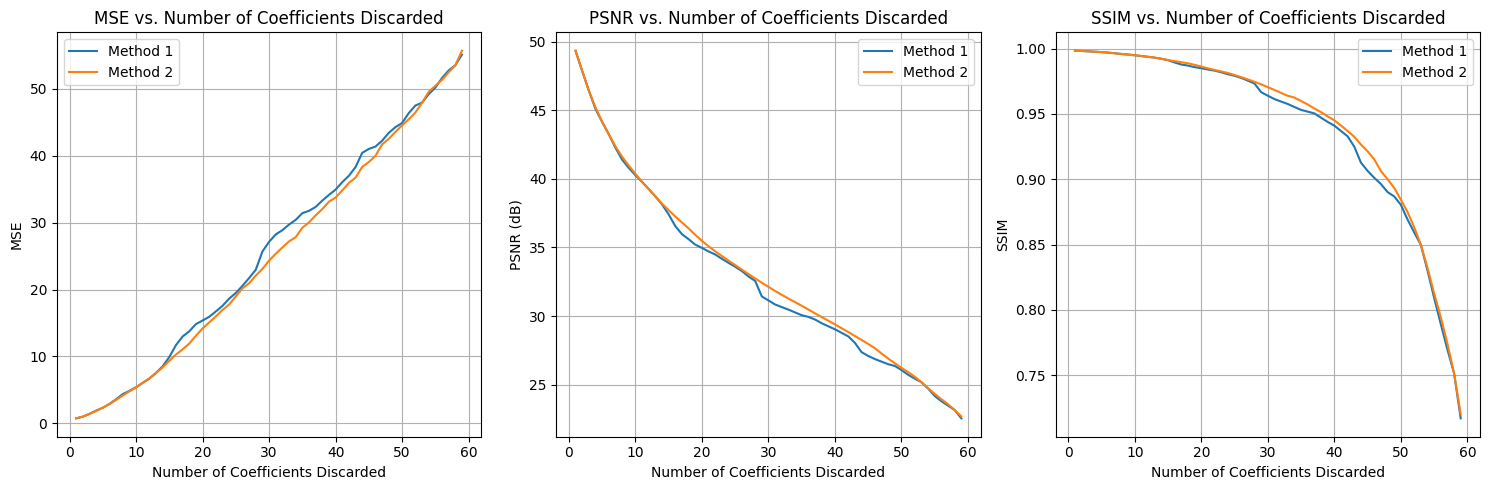

In [ ]:
metrics_list = ["mse", "psnr", "ssim"]
titles = {"mse": "MSE vs. Number of Coefficients Discarded", "psnr": "PSNR vs. Number of Coefficients Discarded", "ssim": "SSIM vs. Number of Coefficients Discarded",}
y_labels = {"mse": "MSE", "psnr": "PSNR (dB)", "ssim": "SSIM",}

fig, axes = plt.subplots(1, len(metrics_list), figsize=(15, 5))
for i, metric in enumerate(metrics_list):
    ax = axes[i]
    ax.plot(range(1, 65), results[metric]["B1"], label="Method 1")
    ax.plot(range(1, 65), results[metric]["B2"], label="Method 2")
    ax.set_xlabel("Number of Coefficients Discarded")
    ax.set_ylabel(y_labels[metric])
    ax.set_title(titles[metric])
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, len(metrics_list), figsize=(15, 5))
for i, metric in enumerate(metrics_list):
    ax = axes[i]
    ax.plot(range(1, 60), results[metric]["B1"][:59], label="Method 1")
    ax.plot(range(1, 60), results[metric]["B2"][:59], label="Method 2")
    ax.set_xlabel("Number of Coefficients Discarded")
    ax.set_ylabel(y_labels[metric])
    ax.set_title(titles[metric])
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

**Code explanation**

we display plots to compare the quality metrics between the two methods of discarding DCT coefficients.
In the first part, we create three subplots (one for each metric). Each plot shows how the metric changes as the number of discarded coefficients increases from 1 to 64. The x-axis represents the number of discarded coefficients, while the y-axis corresponds to the respective metric value (MSE, PSNR, or SSIM).
In the second part, the same metrics are plotted, but the few most important coefficients are preserved to better observe the effects that occur towards the end.
The plots provides a clear visual comparison of the two methods across different metrics.

**Result explanation**

The plots compare the performance of the methods using the metrics as the number of discarded DCT coefficients increases.

A short explanation (because we have already explained in detail in HW1) on the metrics and an explanation on the result:


#### **1. MSE (Mean Squared Error)** - A lower MSE indicates less distortion.
**Formula:** $$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2$$

Where $x_i$ is the original pixel value, $\hat{x}_i$ is the reconstructed pixel value and $N$ is the total number of pixels

**Resule explanation**
- As the number of discarded coefficients increases, the MSE increases steadily for both methods (because we discard more and more important coefficients).
- This indicates that more discarded coefficients result in greater distortion in the reconstructed image. Both methods behave similarly, with slight deviations in some regions.


#### **2. PSNR (Peak Signal-to-Noise Ratio)** - PSNR quantifies the image quality by comparing the maximum possible pixel value to the error introduced by reconstruction. A higher PSNR indicates better image quality.
**Formula:**
$$\text{PSNR} = 10 \cdot \log_{10}\left(\frac{L^2}{\text{MSE}}\right)$$

Where $L$ is the maximum possible pixel value


**Resule explanation**
- PSNR decreases as more coefficients are discarded, showing that the quality of the reconstructed image declines (because we discard more and more important coefficients).
- Both methods show comparable performance, with slight differences in certain regions.


#### **3. SSIM (Structural Similarity Index)** - SSIM evaluates the structural similarity between the original and reconstructed images, considering luminance, contrast, and structure. Its range is $[0, 1]$, where 1 indicates perfect similarity (It is possible to see that when no coefficients are discarded (at 0), the SSIM value is 1.).
**Formula:**
$$\text{SSIM}(x, y) = \frac{2\sigma_{xy}(2\mu_x\mu_y)}{(\mu_x^2 + \mu_y^2)(\sigma_x^2 + \sigma_y^2)}$$

Where $\mu_x$, $\mu_y$ are the mean of $x$ and $y$, $\sigma_x^2$, $\sigma_y^2$ are the variance of $x$ and $y$, $\sigma_{xy}$ is the covariance of $x$ and $y$


**Resule explanation**
- SSIM also decreases as more coefficients are discarded, reflecting a loss in structural similarity to the original image.
- Method 2 slightly outperforms Method 1 for preserving SSIM in certain cases, but overall, the results are closely aligned.


**In summary**

Both methods show a similar trend for all metrics, with minimal performance differences. The consistency suggests that both methods are effective at discarding coefficients while maintaining similar levels of image quality degradation. However, since Method 2 achieves slightly better results in SSIM, we can conclude that it is the better method.

# Section D

##Entropy Calculation Function

In [ ]:
def calculate_entropy(image):
    """Calculate the entropy of an image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=(0, 255), density=True) # Flatten for calculate the histogram
    histogram = histogram[histogram > 0]
    entropy = -np.sum(histogram * np.log2(histogram)) # Entropy formula
    return entropy

**Explanation:**  
The entropy function computes the entropy of an image, which quantifies the amount of information or randomness. It flattens the image, calculates the normalized histogram of pixel values, removes zero probabilities to avoid mathematical errors, and applies the entropy formula:

$$\text{Entropy} = -\sum_{i} p_i \cdot \log_2(p_i)$$

Where $p_i$ is the normalized probability of the $i$-th pixel value in the histogram.

**Entropy Calculation for Reconstructed Images**

In [ ]:
coefficients_to_discard = [list(range(1, i + 1)) for i in range(1, 65)] # List of coefficients to discard
entropy_results = {"B1": [],"B2": []} # Dictionary results

for coeffs in coefficients_to_discard:
    reconstructed_B1 = section_B1(coeffs) # Method 1
    entropy_B1 = calculate_entropy(reconstructed_B1)
    entropy_results["B1"].append(entropy_B1)

    reconstructed_B2 = section_B2(coeffs) # Method 2
    entropy_B2 = calculate_entropy(reconstructed_B2)
    entropy_results["B2"].append(entropy_B2)

**Explanation**

Here we calculates the entropy of reconstructed images for the two methods as a function of the number of discarded DCT coefficients.
The coefficients_to_discard list contains sublists defining the number of coefficients to be discarded (from 1 to 64). For each sublist, the images are reconstructed using method 1 and Method 2. The entropy function is applied to the reconstructed images to compute their entropy, and the results are stored in the entropy_results dictionary for both methods. This allows for comparing how entropy evolves as more coefficients are discarded.

## Entropy Analysis

<Figure size 640x480 with 0 Axes>

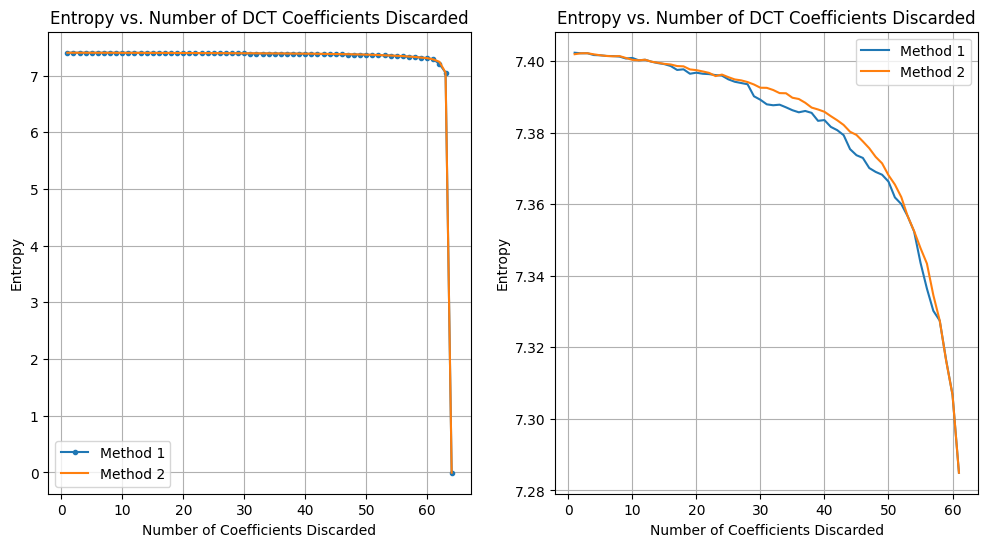

In [ ]:
plt.figure()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 65), entropy_results["B1"], label="Method 1" ,marker='.')
plt.plot(range(1, 65), entropy_results["B2"], label="Method 2")
plt.xlabel("Number of Coefficients Discarded")
plt.ylabel("Entropy")
plt.title("Entropy vs. Number of DCT Coefficients Discarded")
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, 62), entropy_results["B1"][:61], label="Method 1")
plt.plot(range(1, 62), entropy_results["B2"][:61], label="Method 2")
plt.xlabel("Number of Coefficients Discarded")
plt.ylabel("Entropy")
plt.title("Entropy vs. Number of DCT Coefficients Discarded")
plt.legend()
plt.grid(True)
plt.show()

**Code explanation**

We creates 2 plots to visualize how **entropy** changes as a function of the number of discarded DCT coefficients for the two methods.
Left plot displays the entropy for all 64 discarded coefficients for both methods and the Right plot displays the entropy for the first 61 discarded coefficients, allowing a closer examination of the behavior at the beginning.

**Results explanation**
The plots represent how the entropy of reconstructed images evolves as more DCT coefficients are discarded for both methods.
- **Left Plot:**  
  This shows the entropy over the full range of discarded coefficients. For both methods, the entropy remains constant at around 7 for most of the range, reflecting the high randomness and information preservation of the reconstructed images. We can see that near the end, when nearly all coefficients are discarded, the entropy drops sharply to zero as the images lose all meaningful content and become nearly uniform.

- **Right Plot:**  
  In the zoomed range, we can see that method 2 generally produces slightly higher entropy compared to method 1, particularly as more coefficients are discarded. This suggests that method 2 retains slightly more randomness and information in the reconstructed images. The entropy increases gradually as more coefficients are discarded, reflecting the growing uniformity in the reconstructed image blocks.

**Conclusion:**  
Both methods exhibit similar behavior, but method 2 shows a small advantage in retaining entropy, which could indicate better preservation of image information for a given number of discarded coefficients. The sharp drop near the end show the loss of all meaningful content as almost all coefficients are removed.

# Section E

## Entropy Comparison: JPEG vs. Method 2

In [ ]:
qf_values = list(range(0, 101, 1))
entropy_results = {"JPEG": [], "Method 2": []}

for qf in qf_values: # JPEG
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), qf]
    _, encoded_image = cv2.imencode('.jpg', bridge, encode_param)
    decoded_image = cv2.imdecode(encoded_image, cv2.IMREAD_COLOR)

    entropy_jpeg = calculate_entropy(decoded_image)  # Entropy for JPEG
    entropy_results["JPEG"].append(entropy_jpeg)

coefficients_to_discard = [list(range(1, i + 1)) for i in range(1, 65)] # Method 2
for coeffs in coefficients_to_discard:
    reconstructed_B2 = section_B2(coeffs)
    entropy_B2 = calculate_entropy(reconstructed_B2)
    entropy_results["Method 2"].append(entropy_B2)

**Explanation:**  
Here we calculates and compares the entropy of reconstructed images using JPEG compression and method 2. For JPEG, the image is saved and reloaded at different quality factors (QF) ranging from 0 to 100. The entropy of the reconstructed image is computed using the entropy function and stored in entropy_results[JPEG]. And for method 2, the entropy is calculated accordingly.

## Entropy Comparison Between JPEG Compression and Method 2

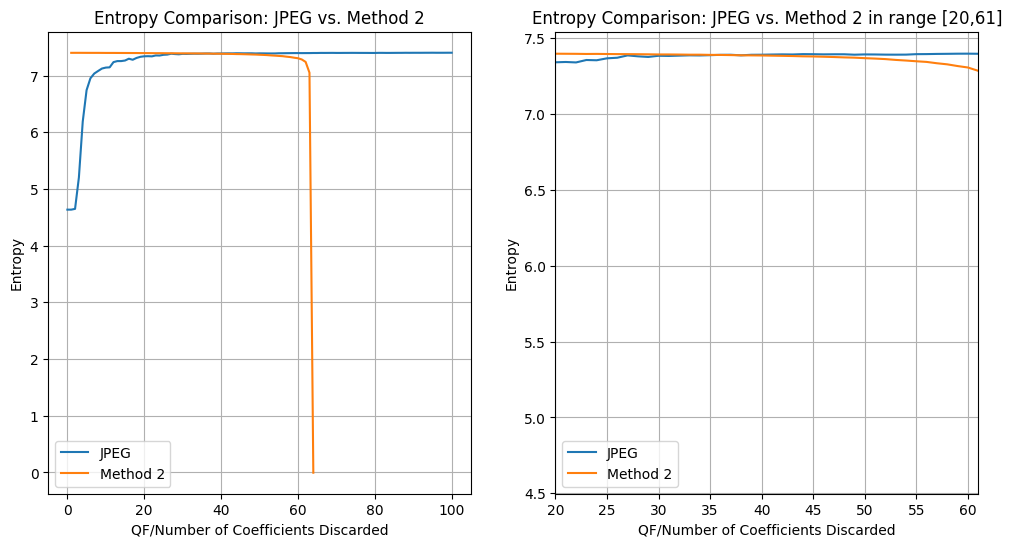

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(qf_values, entropy_results["JPEG"], label="JPEG")
plt.plot(range(1, 65), entropy_results["Method 2"], label="Method 2")
plt.xlabel("QF/Number of Coefficients Discarded")
plt.ylabel("Entropy")
plt.title("Entropy Comparison: JPEG vs. Method 2")
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(qf_values, entropy_results["JPEG"], label="JPEG")
plt.plot(range(1, 62), entropy_results["Method 2"][:61], label="Method 2")
plt.xlabel("QF/Number of Coefficients Discarded")
plt.ylabel("Entropy")
plt.title("Entropy Comparison: JPEG vs. Method 2 in range [20,61]")
plt.legend()
plt.grid(True)
plt.xlim(20, 61)
plt.show()

**Code explanation**

We creates two subplots to compare the entropy. Like before the left displays the full range of entropy values for JPEG (based on quality factor qf_values) and method 2 (based on the number of discarded coefficients). And the right plot is zoomed for a closer comparison of the entropy trends for both methods.  

**Result explanation**
**Left Plot:**  
  - For JPEG we can see that the entropy increases rapidly as QF improves (higher quality), stabilizing at a near-maximum value around QF = 20 and remaining constant for higher QF values. And for method 2, the entropy remains high and consistent up to around 60 discarded coefficients, after which it sharply drops to zero, reflecting the complete loss of meaningful content in the reconstructed images.

**Right Plot:**  
  - We can see that both methods maintain high entropy within this range, with JPEG showing slightly higher values than Method 2. The small differences indicate that JPEG compression retains more randomness or information compared to Method 2 in this range.

**Conclusion:**  
JPEG compression stabilizes entropy quickly at lower QF values, keeping the image information effectively. Method 2 also keeps high entropy initially but drops sharply when too many coefficients are discarded, showing a limit to how much content it can preserve.


## Quality Metrics Comparison Between JPEG and Method 2 Based on Matching Entropy

In [ ]:
# Extract the entropy results
entropy_method2 = entropy_results["Method 2"]
entropy_jpeg = entropy_results["JPEG"]
matching_indices = []
for ent2 in entropy_method2:
    closest_index = np.argmin(np.abs(np.array(entropy_jpeg) - ent2)) # Find the closest matching
    matching_indices.append(closest_index)

quality_results = {"mse": {"JPEG": [], "Method 2": []},"psnr": {"JPEG": [], "Method 2": []},"ssim": {"JPEG": [], "Method 2": []},}

for idx, coeffs in enumerate(coefficients_to_discard): # Calculate the quality metrics
    reconstructed_B2 = section_B2(coeffs) # Method 2
    mse_B2 = MSE(bridge, reconstructed_B2)
    psnr_B2 = PSNR(bridge, reconstructed_B2)
    ssim_B2 = SSIM(bridge, reconstructed_B2)

    closest_index = matching_indices[idx] # JPEG
    qf = qf_values[closest_index]
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), qf]
    _, encoded_image = cv2.imencode('.jpg', bridge, encode_param)
    decoded_image = cv2.imdecode(encoded_image, cv2.IMREAD_COLOR)

    mse_jpeg = MSE(bridge, decoded_image)
    psnr_jpeg = PSNR(bridge, decoded_image)
    ssim_jpeg = SSIM(bridge, decoded_image)

    quality_results["mse"]["JPEG"].append(mse_jpeg)
    quality_results["psnr"]["JPEG"].append(psnr_jpeg)
    quality_results["ssim"]["JPEG"].append(ssim_jpeg)
    quality_results["mse"]["Method 2"].append(mse_B2)
    quality_results["psnr"]["Method 2"].append(psnr_B2)
    quality_results["ssim"]["Method 2"].append(ssim_B2)

**Explanation**  
And again here we compares the quality metrics of JPEG compression and method 2 based on matching entropy levels. For each entropy value of method 2, the closest corresponding entropy value in JPEG is found using np.argmin.
For method 2, the reconstructed image is generated by progressively discarding coefficients, and its quality metrics are calculated.  And for JPEG, the corresponding quality factor (QF) is used to compress and decompress the image, and its quality metrics are computed.  
The results are stored in the quality_results dictionary for both methods, enabling direct comparison of metrics at equivalent entropy levels.


## Quality Metrics Comparison: JPEG vs. Method 2 Based on Entropy

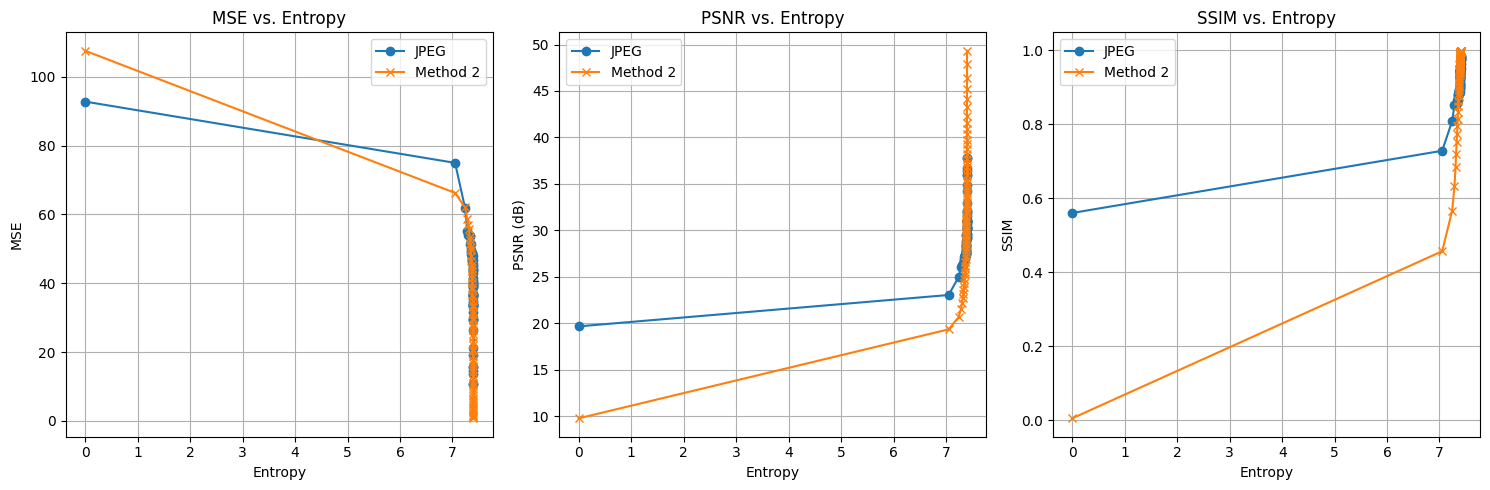

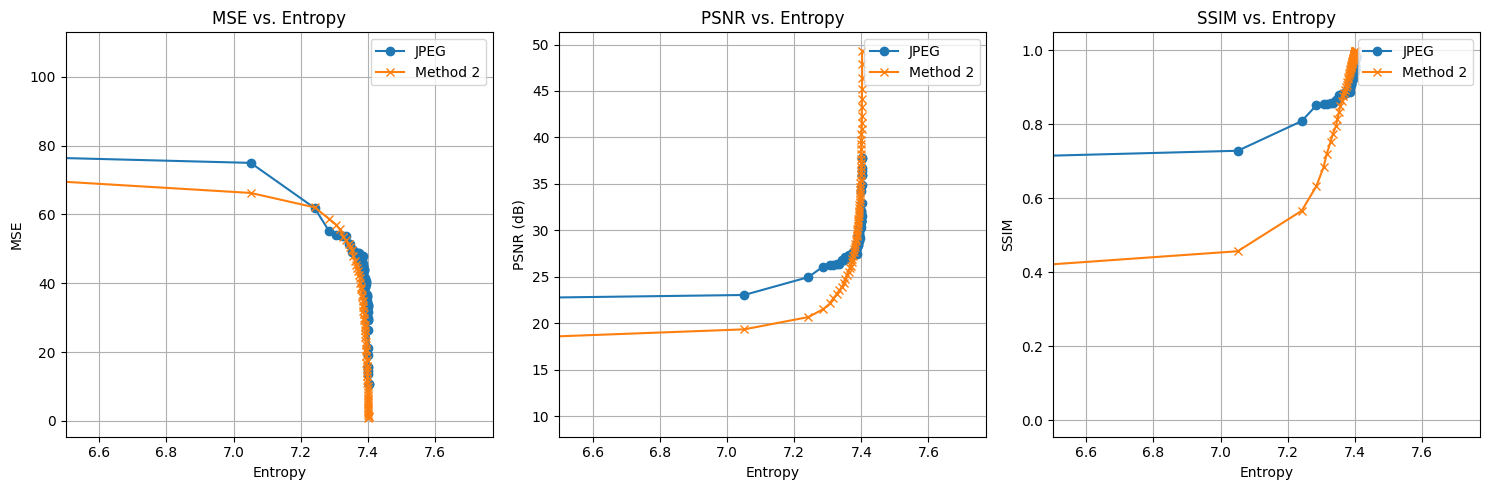

In [ ]:
metrics_list = ["mse", "psnr", "ssim"]
titles = {"mse": "MSE vs. Entropy","psnr": "PSNR vs. Entropy","ssim": "SSIM vs. Entropy",}
y_labels = {"mse": "MSE","psnr": "PSNR (dB)","ssim": "SSIM",}

fig, axes = plt.subplots(1, len(metrics_list), figsize=(15, 5))
for i, metric in enumerate(metrics_list):
    ax = axes[i]
    ax.plot(entropy_method2, quality_results[metric]["JPEG"], label="JPEG", marker='o')
    ax.plot(entropy_method2, quality_results[metric]["Method 2"], label="Method 2", marker='x')
    ax.set_xlabel("Entropy")
    ax.set_ylabel(y_labels[metric])
    ax.set_title(titles[metric])
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(metrics_list), figsize=(15, 5))
for i, metric in enumerate(metrics_list):
    ax = axes[i]
    ax.plot(entropy_method2, quality_results[metric]["JPEG"], label="JPEG", marker='o')
    ax.plot(entropy_method2, quality_results[metric]["Method 2"], label="Method 2", marker='x')
    ax.set_xlabel("Entropy")
    ax.set_ylabel(y_labels[metric])
    ax.set_title(titles[metric])
    ax.legend()
    ax.grid(True)
    ax.set_xlim(left=6.5)
plt.tight_layout()
plt.show()

**Code explanation**  
We visualizes the quality metrics for JPEG compression and Method 2 as a function of entropy.
In the first set of plots, the full range of entropy values is displayed for both methods. And in the second set, the x-axis is limited to entropy values greater than 6.5 to focus on the relevant range where differences are more apparent.

**Result explanation**
1. **For Full Entropy Range Graphs**  
   We can see that JPEG is maintains stable performance with higher entropy values. As entropy decreases, indicating stronger compression, the quality metrics gradually decline but remain consistent. And mMethod 2 shows a sharp decline in quality metrics at low entropy values. And again this is because, at lower entropy, most of the significant coefficients are discarded, leading to severe quality degradation.

2. **For The Zoomed Entropy Range Graphs**  
  - For **MSE**, JPEG has consistently lower MSE compared to Method 2, showing that JPEG preserves image accuracy better at similar entropy levels.  
  - For **PSNR**, JPEG outperforms Method 2, reflecting better image fidelity.  
  - For **SSIM**, JPEG has higher SSIM values, indicating superior structural similarity to the original image.

**Conclusion**
We can see that JPEG consistently provides better image quality across all metrics compared to method 2, particularly at higher entropy levels. Method 2 struggles to maintain quality as entropy decreases due to its reliance on discarding coefficients in a less efficient manner.
In conclusion, JPEG consistently provides better image quality across all metrics compared to Method 2, particularly at higher entropy levels. Method 2 struggles to maintain quality as entropy decreases due to its reliance on discarding coefficients in a less efficient manner.